## Постановка задачи

Необходимо придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами: закон смещения Вина, закон Стефана-Больцмана, спектральный анализ. Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. В нашем распоряжении следующие **характеристики**:
- Относительная светимость **L/Lo** — светимость звезды относительно Солнца;
- Относительный радиус **R/Ro** — радиус звезды относительно радиуса Солнца;
- Абсолютная звёздная величина **Mv** — физическая величина, характеризующая блеск звезды;
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
- Тип звезды:
    - Коричневый карлик	0
    - Красный карлик	1
    - Белый карлик	2
    - Звёзды главной последовательности	3
    - Сверхгигант	4
    - Гипергигант	5
- Абсолютная температура **T(K)** — температура на поверхности звезды в Кельвинах.

**Задача**: разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

**Этапы работы**: 
- Знакомство с данными (загрузка)
- Анализ и предобработка данных
- Построение базовой нейросети
- Улучшение прошлой версии нейросети
- Выводы

## Необходимые дополнения

In [1]:
# Испортируем необходимые библиотеки

#conda activate env-name

#conda update conda
#conda install scikit-learn=1.2.1

import warnings

#!pip install pyparsing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

#!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer

In [2]:
# Пропишем необходимые функции

def data_info(df):
    '''Информации о DF. Методы: describe, info, с просмотром памяти'''
    print(f'Размеры DF: {df.shape}', '\n')
    display(df.head(10), df.describe(), df.info(memory_usage='deep'))

def data_spread(column_list, df):
    '''Разброс данных. Отображение диаграммы размаха и гистограммы. Входные данные list колонок и df'''
    for column in column_list:
        df.boxplot(column=column)
        plt.title(f'Диаграмма размаха на столбце {column}')
        plt.show()
        df[column].plot(kind='hist', bins=100, grid=True)
        plt.title(f'Гистограмма на столбце {column}')
        plt.xlabel(column)
        plt.ylabel('Кол-во наблюдений')
        plt.show()
        print('--------------------------------------------')

def uniqueness(colomn_list, df):
    '''Просмотр уникальных значений листа'''
    for column in colomn_list:
        print(f'Количество уникальных значений столбца {column}: {df[column].nunique()}')
        print(df[column].unique())
        print('-----------------------------')

## Знакомство с данными

In [3]:
try:
    data = pd.read_csv('C:\\Users\\Legion 5\\Desktop\\Учёба\\Data scince\\Проекты\\Практика\\Яндекс практикум\\Температура звёзд\\df.csv', index_col = 0)
except:
    data = pd.read_csv('/datasets/6_class.csv', index_col = 0)
data_info(data)

Размеры DF: (240, 6) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 25.8 KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
5,2840,0.000650,0.1100,16.98,0,Red
6,2637,0.000730,0.1270,17.22,0,Red
7,2600,0.000400,0.0960,17.40,0,Red
8,2650,0.000690,0.1100,17.45,0,Red
9,2700,0.000180,0.1300,16.05,0,Red


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


None

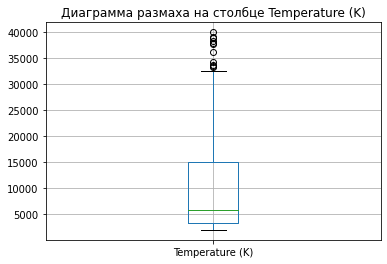

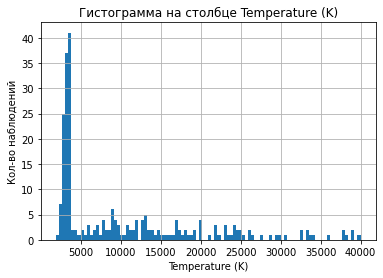

--------------------------------------------


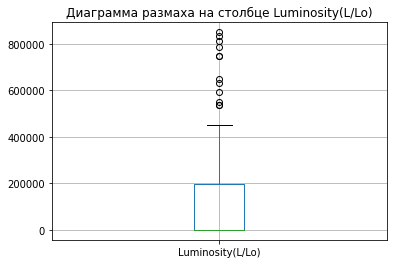

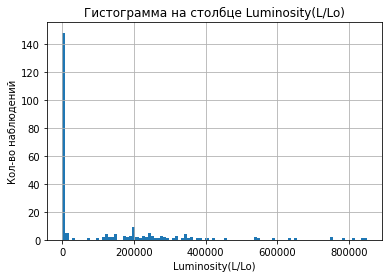

--------------------------------------------


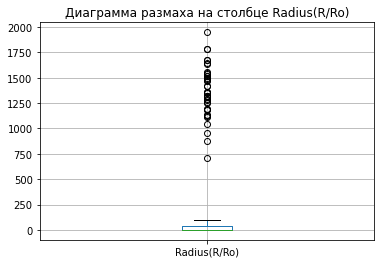

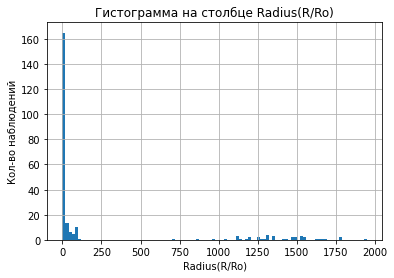

--------------------------------------------


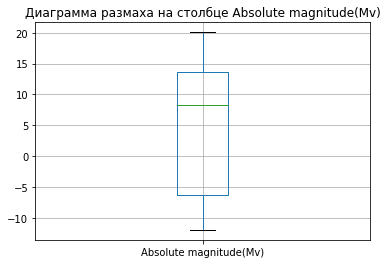

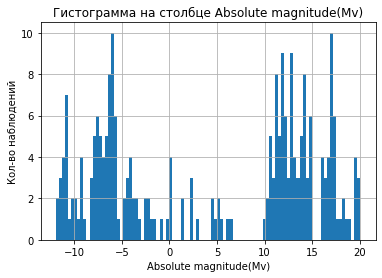

--------------------------------------------


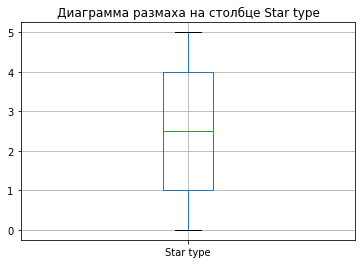

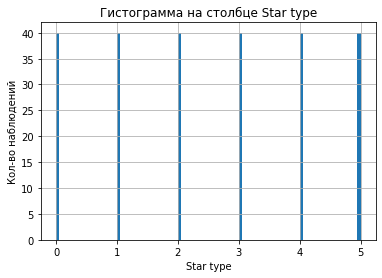

--------------------------------------------


In [4]:
# Посмотрим на разброс данных
data_spread(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type'], data)

In [5]:
# Проверим корректность категориальных данных
uniqueness(['Star type', 'Star color'], data)

Количество уникальных значений столбца Star type: 6
[0 1 2 3 4 5]
-----------------------------
Количество уникальных значений столбца Star color: 19
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']
-----------------------------


In [6]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [7]:
# Убедимся в корректносте аномалий
display(data.corr())
display(data.loc[data['Temperature (K)'] > 32000].sort_values(by=['Temperature (K)']))
display(data.loc[data['Luminosity(L/Lo)'] > 100000].sort_values(by=['Luminosity(L/Lo)']))
display(data.loc[data['Radius(R/Ro)'] > 500].sort_values(by=['Radius(R/Ro)']))

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
Temperature (K),1.000000,0.393404,0.064216,-0.420261,0.411129
Luminosity(L/Lo),0.393404,1.000000,0.526516,-0.692619,0.676845
Radius(R/Ro),0.064216,0.526516,1.000000,-0.608728,0.660975
Absolute magnitude(Mv),-0.420261,-0.692619,-0.608728,1.000000,-0.955276
Star type,0.411129,0.676845,0.660975,-0.955276,1.000000


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
215,32460,173800.0,6.237,-4.36,3,Blue
232,32489,648430.0,1948.500,-10.84,5,Blue
100,33300,240000.0,12.000,-6.50,4,Blue
109,33421,352000.0,67.000,-5.79,4,Blue
49,33750,220000.0,26.000,-6.10,4,Blue
214,34190,198200.0,6.390,-4.57,3,Blue
99,36108,198000.0,10.200,-4.40,3,Blue
159,37800,202900.0,6.860,-4.56,3,Blue
239,37882,294903.0,1783.000,-7.80,5,Blue
231,38234,272830.0,1356.000,-9.29,5,Blue


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
104,11096,112000.0,12.0,-5.910,4,Blue
113,3399,117000.0,1486.0,-10.920,5,Red
178,12100,120000.0,708.9,-7.840,5,Blue-white
46,3575,123000.0,45.0,-6.780,4,Red
111,3605,126000.0,1124.0,-10.810,5,Red
...,...,...,...,...,...,...
229,21738,748890.0,92.0,-7.346,4,Blue
227,10930,783930.0,25.0,-6.224,4,Blue
101,40000,813000.0,14.0,-6.230,4,Blue
236,30839,834042.0,1194.0,-10.630,5,Blue


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
178,12100,120000.0,708.9,-7.84,5,Blue-white
117,3625,74000.0,876.0,-10.25,5,Red
58,3752,209000.0,955.0,-11.24,5,Red
176,18000,200000.0,1045.0,-8.30,5,Blue
238,9235,404940.0,1112.0,-11.23,5,White
111,3605,126000.0,1124.0,-10.81,5,Red
234,21904,748490.0,1130.0,-7.67,5,Blue-white
179,24490,248490.0,1134.5,-8.24,5,Blue-white
52,3834,272000.0,1183.0,-9.20,5,Red
174,3600,240000.0,1190.0,-7.89,5,Red


### Вывод

Нам предоставлен датасет с 240 наблюдениями, которые охарактеризованы 2 категориальными (Star type, Star color) и 4 численными  (Temperature (K), Luminosity(L/Lo), Radius(R/Ro), Absolute magnitude(Mv)) признаками. Temperature (K) наш целевой показатель - нам необходимо научить модель предсказывать именно его, поэтому важно было проверить данные на аномалии, а точнее на ошибки. Если говорить про распределение в данных, то можно заметить, что в каждом признаке есть свои выбросы. Поговорим про каждый из них:
- Temperature (K) - наше медианное значение стоит чуть выше 5000 (К), в целом в данном датасете большинство наблюдений показывают температуру звезды в районе 3500-4000 Кельвинов, что является среднестатистической нормой температуры звёзд. Однако существуют значения, которые выходят за пределы усов (>32500 Кельвинов), удалять эти значения мы не будем, во-первых, потому что это наш целевой признак, во-вторых, подобная температура звёзд возможна: "По оценке учёных, показатели отдельных светил разные. Более холодные обладают теплом 2000-5000 К, средняя температура (у жёлтых и оранжевых) тел составляет 5000-7500 К, а горячие представители достигают значений 7500-80000 К." ([Источник](https://kosmosgid.ru/zvyozdy/temperatura-zvezd)).
- Luminosity(L/Lo) - большинство звёзд в нашей выборке имеют очень маленькую светимость относительно Солнца (медианное значение весьма близко к нулю). Однако есть наблюдения, которые выходят за пределы и начинаются от 100.000, статья в интернете говорит о том, что такое вполне уместно в нашей необъятной вселенной, всё зависит от радиуса и температуры, а также существуют звёзды, которые в 8.100.000 раз светлее нашего Солнца ([Источник](https://www.atnf.csiro.au/outreach/education/senior/astrophysics/photometry_luminosity.html)). Также, судя по корреляционной матрице и выборке, слова о зависимости, написанные в статье выше, подтверждаются, мы это можем наблюдать на радиусе и Температуре. Все высокие показатели у признака обусловлены высокими показателями у других. Поэтому удалять мы их не будем.
- Radius(R/Ro) - здесь всё как в прошлом признаке: большинство наблюдений имеют меньший радиус, по сравнению с нашей Звездой (медианное значение в районе 0), однако существуют звёзды, которые превышают размеры Солнца в несколько тысяч раз. Для них всех характерна принадлежание к типу звезды Гипергигант (5). Поэтому мы не будем удалять подобные значения.
- Absolute magnitude(Mv) - признак без выбросов, который имеет бимодальное распределение, практически зеркальное в отрицательной и положительной частях графика. Меньше всего значений в диапазоне 0-5.
- Star type - категориальный столбец, по которому мы можем увидеть, что нам предоставили по 40 наблюдений каждого класса.

Вернёмся к нашему DF и ошибкам, которые были обнаружены во время знакомства с его данными. Наименование столбцов корректны, типы данных в порядке, а NaN значения отсутствуют. В дальнейшем необходимо будет пременить прямое кодирование к категориальным столбцам, а также маштабирование численных признаков. Однако не всё так хорошо, в столбце Star color есть неявные дубликаты из-за разного регистра букв, а также некоторые слова написаны с перестановкой (blue-white и white-blue) и без тире, это необходимо будет исправить на этапе предобработки данных. Подобные ошибки случаются из-за человечествого фактора - каждый гаразд писать как он хочет.

## Предобработка данных

In [8]:
# Поработаем с неявными дубликатами
data['Star color'] = data['Star color'].replace('blue white', 'blue-white')
data['Star color'] = data['Star color'].replace(['yellow-white', 'yellowish white'], 'white-yellow')
data['Star color'] = data['Star color'].str.lower()
data['Star color'] = data['Star color'].str.strip(to_strip = None)
uniqueness(['Star type', 'Star color'], data)

Количество уникальных значений столбца Star type: 6
[0 1 2 3 4 5]
-----------------------------
Количество уникальных значений столбца Star color: 12
['red' 'blue white' 'white' 'yellowish white' 'pale yellow orange' 'blue'
 'blue-white' 'whitish' 'white-yellow' 'orange' 'yellowish' 'orange-red']
-----------------------------


In [9]:
print(f'Количество явны дубликатов = {data.duplicated().sum()}')

Количество явны дубликатов = 0


### Вывод

По результатам предобработки данных были исправлены ошибки в столбце Star color, связанные с неявными дубликатами в словах, что позволило сократить количество уникальных значений с 19 до 12 штук. Явные дубликаты не были обнаружены.

## EDA

interval columns not set, guessing: ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']


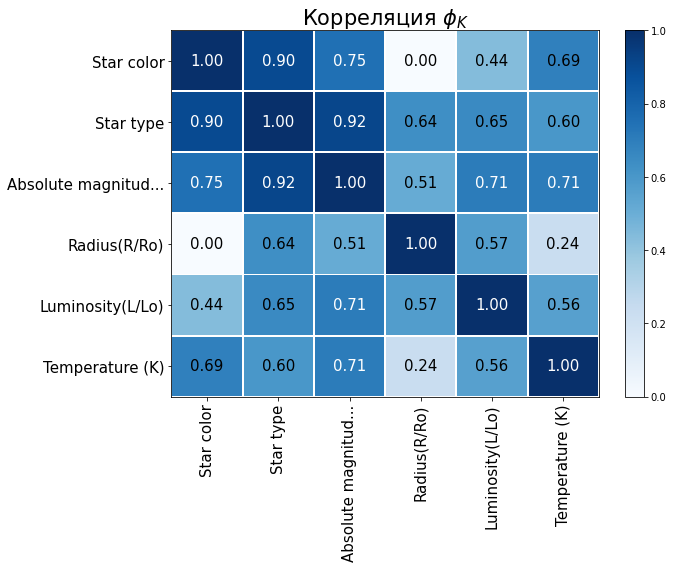

In [10]:
# Воспользуемся корреляцией Phik

phik_overview = data.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()
plt.show()

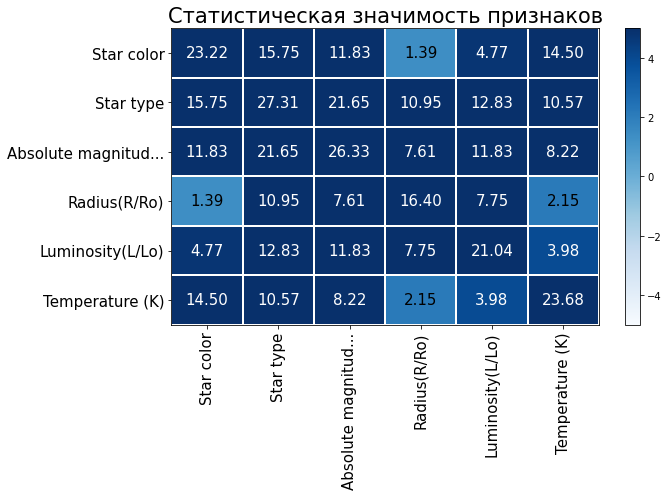

In [11]:
# Посмотрим на статистическую значимость

significance_overview = data.significance_matrix(interval_cols=['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type'])
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Статистическая значимость признаков", 
                        usetex=False, fontsize_factor=1.5, figsize=(10, 7), color_map="Blues")
plt.tight_layout()

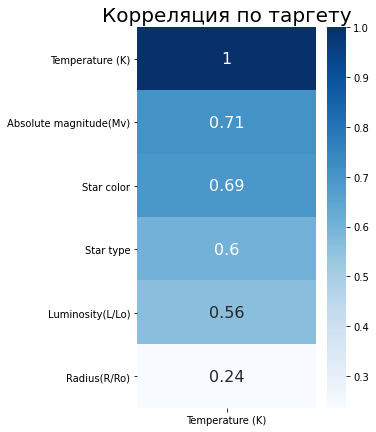

In [12]:
# Посмотрим корреляцию по нашему таргету
plt.figure(figsize=(4, 7))
sns.heatmap(phik_overview.sort_values(by = 'Temperature (K)', ascending=False)[['Temperature (K)']], cmap='Blues', annot=True, annot_kws={'size':16}, fmt='.2g')
plt.title('Корреляция по таргету', fontsize=20)
plt.show()

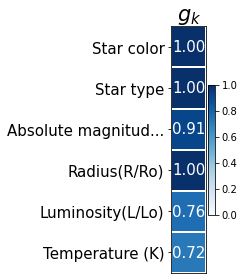

In [13]:
# Посмотрим на глобальную корреляцию признаков

global_correlation, global_labels = data.global_phik(interval_cols=['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type'])

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Blues", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

### Вывод

Первое, что хочется заметить и что явно бросается в глаза - это мультикорреляция между столбцом Star type и Absolute magnitude(Mv), равная 90% по корреляции phik. Однако удалять мы один из данных признаков не будет, тк они имеют большую статистическую значимость равную 21,61. Теперь вернёмся к вопросу о взаимосвязи таргета с нашими фичами:
- 'Luminosity(L/Lo)' - 56% корреляция. В любой статье можно наткнуться на слова о том, что главным фактором температуры звезды является его цвет, но фактически светимость звезды относительно Солнца позволяет нам понять насколько звезда теплая, хоть и не явно. 
- 'Absolute magnitude(Mv)' - 71% корреляция. Это физическая величина, характеризующая блеск астрономического объекта для наблюдателя, находящегося на некотором стандартном расстоянии от объекта. Использование абсолютной звёздной величины позволяет сравнивать действительную, а не наблюдаемую светимость объектов. Поэтому она очень схожа с понятием относительная светимость.
- Star color - 69% корреляция. Как я уже писал выше, одним из важнейших показателей температуры звезды является его цвет, скорее всего это вызвано приломлением светового луча, который доходит до нашей планеты.
- Star type - 60% корреляцияс нашим признаком. Всё просто у нас есть пять основных типов звёзд и по ним возможно понять их температуру, с точки зрения статистики и наблюдений.
- 'Radius(R/Ro)' - самая маленькая корреляция, равная всего 24%. Возможно это связано с природой, а точнее с плотностью и массой звёзд, ведь не важно какой объект будет по размерам, важнее из чего он состоит и каким цветом будет светить.

К сожалению для нас, из глобальной корреляции (она дает нам представление о том, насколько хорошо одна переменная может быть смоделирована с использованием других переменных) мы можем понять, что самым плоховырожающимся вектором является Температура звезды - 72%.

## Подготовка данных

In [14]:
# Включим вывод предупреждений
warnings.filterwarnings('default')

In [15]:
# Разделим нашу выборку
X_train, X_test, y_train, y_test = train_test_split(data.drop('Temperature (K)', axis = 1),
                                                    data['Temperature (K)'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(192, 5) (48, 5) (192,) (48,)


In [16]:
# Поставим ограничений на число столбцов
pd.set_option('display.max_rows', 10)

In [17]:
numerics = ['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)']
categorical = ['Star color', 'Star type']

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False), categorical)],
                                remainder="passthrough"
                                  )

col_transformer.fit(data.drop('Temperature (K)', axis=1))
X_train = col_transformer.transform(X_train)
X_test = col_transformer.transform(X_test)

## Построение базовой нейронной сети

In [18]:
# Переведём выборки в тензоры
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))

In [19]:
# Создадим ПНС
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

In [20]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

In [21]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)    

In [22]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [23]:
# Обучим нейросеть
early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

num_epochs = 100001
for epoch in range(num_epochs):
    net.train()
    for batch in train_dataloader:
        data_train, temperature_train = batch # просто выгружаем данные 
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        loss_value.backward()
        optimizer.step()
    
    if epoch % 200 == 0:
        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch # просто выгружаем данные

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = mean_squared_error(y_test, predicted_temp, squared=False)
        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse = RMSE
            best_predicted_temp = predicted_temp
        print(f"epoch:{epoch}, RMSE test: {RMSE}")

        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best RMSE test {best_rmse}')
            break 

epoch:0, RMSE test: 15201.345703125
epoch:200, RMSE test: 13350.8701171875
epoch:400, RMSE test: 8286.552734375
epoch:600, RMSE test: 7294.251953125
epoch:800, RMSE test: 6664.1357421875
epoch:1000, RMSE test: 6109.921875
epoch:1200, RMSE test: 5698.17236328125
epoch:1400, RMSE test: 5439.216796875
epoch:1600, RMSE test: 5283.0205078125
epoch:1800, RMSE test: 5174.10595703125
epoch:2000, RMSE test: 5086.2841796875
epoch:2200, RMSE test: 5002.56591796875
epoch:2400, RMSE test: 4932.09130859375
epoch:2600, RMSE test: 4873.26171875
epoch:2800, RMSE test: 4818.49560546875
epoch:3000, RMSE test: 4773.0009765625
epoch:3200, RMSE test: 4737.67822265625
epoch:3400, RMSE test: 4703.9453125
epoch:3600, RMSE test: 4671.8837890625
epoch:3800, RMSE test: 4642.59814453125
INFO: Early stopping counter 1 of 5
epoch:4000, RMSE test: 4624.48388671875
INFO: Early stopping counter 2 of 5
epoch:4200, RMSE test: 4624.0556640625
epoch:4400, RMSE test: 4597.5400390625
INFO: Early stopping counter 1 of 5
epoch

In [24]:
def fact_forecast(test_preds, y_test):
    
    '''Функция для визуализации качества регрессии "Факт-прогноз"'''
    
    y1 = torch.FloatTensor(test_preds)
    y1 = y1.detach().numpy().reshape([-1])
    y2 = y_test.detach().numpy().reshape([-1])
    x = np.arange(len(y1))

    fig,ax = plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(8)
    ax.set_xticks(x)
    fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
    forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Номер звезды')
    ax.set_ylabel('Температура звезды')
    plt.show()

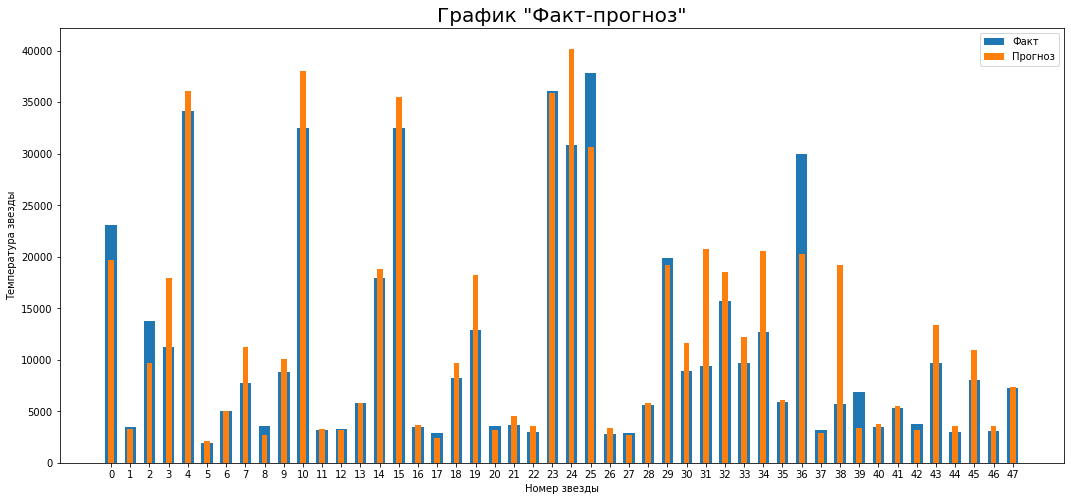

In [25]:
# Визуализируем полученные значения
fact_forecast(predicted_temp, y_test)

### Вывод

Нам удалось обучить baseline без дополнительных введений и перебора параметров. Лучшая метрика RMSE до начала переобучения равна 4137. Однако, это не лучший результат, которого мы можем добиться, далее будем улучшаять нашу НС. Судя по графику факт-прогноз мы отлично угадываем температуру звёзд с минимальным отклонением до 5000 градусов по Кельвину. Далее алгоритм начинает брать то выше правильного ответа, то ниже, скорее всего это связано с небольшим количеством подобных звёзд в нашей выборке, НС просто не смогла правильно научиться на таком малом количестве данных. 

## Улучшение нейронной сети

In [26]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.NAdam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)
optimizer4 = torch.optim.Adamax(net.parameters(), lr=1e-3)
optimizer5 = torch.optim.Adam(net.parameters(), lr=1e-2)

optimizers = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5]


In [27]:
rmse_optimizers = []
for optimizer in optimizers:
    print(optimizer)
    print()

    early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

    num_epochs = 100001
    for epoch in range(num_epochs):
        net.train()
        for batch in train_dataloader:
            data_train, temperature_train = batch # просто выгружаем данные 
            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()

            loss_value = torch.sqrt(loss(preds, temperature_train))
            loss_value.backward()
            optimizer.step()

        if epoch % 200 == 0:
            predicted_temp = [] 
            with torch.no_grad():
                net.eval()
                for batch in test_dataloader:
                    data_test, temperature_test = batch # просто выгружаем данные

                    test_preds = net.forward(data_test).flatten()
                    predicted_temp.append(test_preds)
                    RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

            predicted_temp = torch.cat(predicted_temp).detach().numpy()
            RMSE = mean_squared_error(y_test, predicted_temp, squared=False)
            early_stopping(RMSE)
            if early_stopping.counter == 0:
                best_rmse = RMSE
                best_predicted_temp = predicted_temp
            print(f"epoch:{epoch}, RMSE test: {RMSE}")

            if early_stopping.early_stop:
                print('Early Stoppning!!!')
                print(f'Best RMSE test {best_rmse}')
                rmse_optimizers.append(round(best_rmse, 2))
                break 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

epoch:0, RMSE test: 15201.201171875
epoch:200, RMSE test: 14110.0771484375
epoch:400, RMSE test: 9668.431640625
epoch:600, RMSE test: 7678.5341796875
epoch:800, RMSE test: 7153.87158203125
epoch:1000, RMSE test: 6643.35205078125
epoch:1200, RMSE test: 6182.65283203125
epoch:1400, RMSE test: 5817.25732421875
epoch:1600, RMSE test: 5553.5556640625
epoch:1800, RMSE test: 5384.0380859375
epoch:2000, RMSE test: 5277.14501953125
epoch:2200, RMSE test: 5199.23876953125
epoch:2400, RMSE test: 5130.025390625
epoch:2600, RMSE test: 5064.47216796875
epoch:2800, RMSE test: 5010.10595703125
epoch:3000, RMSE test: 4962.36376953125
epoch:3200, RMSE test: 4925.13916015625
epoch:3400, RMSE test: 4884.00244140625
epoch:3600, RMSE test: 4857.908203125
epoch:3800, RMSE test: 4826.2919921875
epoch:4000, RMSE test: 4796.85693359375
INFO: Early stopping counter 1 of 5
epoch:4200, RMSE test:

In [28]:
optimizers_rmse = pd.DataFrame(data = rmse_optimizers, index = ['Adam, lr: 0.001',
                                                                'NAdam, lr: 0.01',
                                                                'Adamax, lr: 0.01',
                                                                'Adamax, lr: 0.001',
                                                                'Adam, lr: 0.01'], columns = ['RMSE'])
display(optimizers_rmse.sort_values(by='RMSE'))

,RMSE
"NAdam, lr: 0.01",4110.589844
"Adam, lr: 0.01",4137.419922
"Adamax, lr: 0.001",4153.410156
"Adamax, lr: 0.01",4155.839844
"Adam, lr: 0.001",4674.250000


In [29]:
# Добавим регуляризацию на лучшем оптимизаторе

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp2 = nn.Dropout(p=0.5)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

In [30]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

In [31]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)  

In [32]:
# Обучим нейросеть
early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

num_epochs = 100001
val_loss = []
train_loss = []

for epoch in range(num_epochs):
    net.train()
    train_loss_batches = []
    for batch in train_dataloader:
        data_train, temperature_train = batch # просто выгружаем данные 
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        
        loss_value.backward()
        optimizer.step()
        
        loss_value = loss_value.detach().numpy().reshape([-1])
        train_loss_batches.append(loss_value)
    
        
    if epoch % 200 == 0:
        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch # просто выгружаем данные

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = mean_squared_error(y_test, predicted_temp, squared=False)
        
        
        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse = RMSE
            best_predicted_temp = predicted_temp
            val_loss.append(best_rmse)
            train_loss.append(np.mean(train_loss_batches))
        print(f"epoch:{epoch}, RMSE test: {RMSE}")
        
        
        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best RMSE test {best_rmse}')
            break 

epoch:0, RMSE test: 15201.1953125
epoch:200, RMSE test: 4403.681640625
INFO: Early stopping counter 1 of 5
epoch:400, RMSE test: 4394.048828125
epoch:600, RMSE test: 4370.4619140625
epoch:800, RMSE test: 4224.994140625
INFO: Early stopping counter 1 of 5
epoch:1000, RMSE test: 4309.23388671875
INFO: Early stopping counter 2 of 5
epoch:1200, RMSE test: 4215.41552734375
epoch:1400, RMSE test: 4133.5302734375
INFO: Early stopping counter 1 of 5
epoch:1600, RMSE test: 4258.98095703125
epoch:1800, RMSE test: 4006.137451171875
INFO: Early stopping counter 1 of 5
epoch:2000, RMSE test: 4125.7265625
INFO: Early stopping counter 2 of 5
epoch:2200, RMSE test: 4142.8115234375
INFO: Early stopping counter 3 of 5
epoch:2400, RMSE test: 4271.275390625
INFO: Early stopping counter 4 of 5
epoch:2600, RMSE test: 4126.65966796875
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:2800, RMSE test: 4308.6220703125
Early Stoppning!!!
Best RMSE test 4006.137451171875


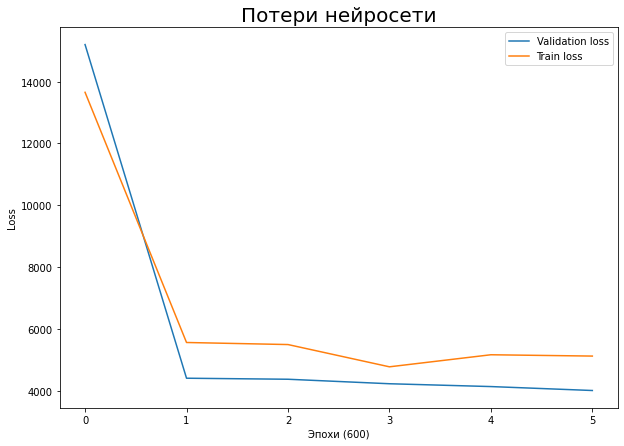

In [33]:
x = np.arange(len(val_loss))

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(7)
ax.set_xticks(x)
val = ax.plot(x, val_loss, label = 'Validation loss')
train = ax.plot(x, train_loss, label = 'Train loss')
ax.legend()
ax.set_title('Потери нейросети', fontsize=20)
ax.set_xlabel('Эпохи (600)')
ax.set_ylabel('Loss')
plt.show()

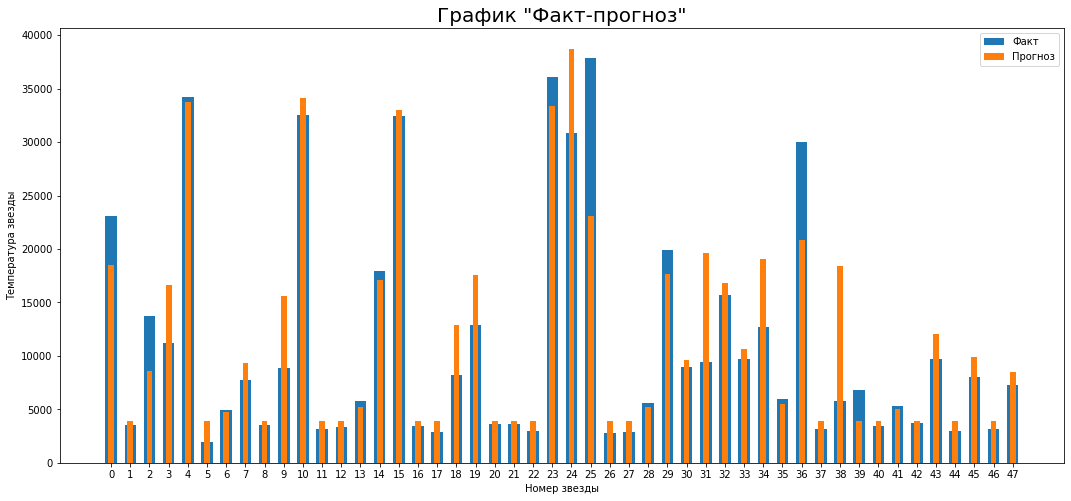

In [34]:
fact_forecast(predicted_temp, y_test)

## Выводы

МЫ провели перебор оптимизаторов, чтобы выявить лучший из 5 представленных, с учётом шага. На данном шаге я не учитывал скорость алгоритмов, судить будем только по конечной RMSE. Судя по метрикам, лучшим оптимизатором для этой задачи является NAdam с шагом равной одной сотой (RMSE = 4110). На нём мы провели конечное улучшение модели: добавили dropout равный 50% и регуляризацию весов BatchNorm1d на первый скрытый слой. Время обучения сильно увеличилась, однако это способстовало улучшению метрики на 100 градусов. Конечная метрика RMSE в улучшинной НС равна 4006. Если посмотреть на график потерь нашей последней нейросети, то можно увидеть, что модель обучилась качественно, без недо/переобучений, благодаря ранней остановке. График фкт-прогноз схож с графиком от baseline, однако мы можем чётко увидеть, что начал предсказывать лучше до 15000 и свыше 30000 градусов по Кельвину.